# Computational Fourier Optics

This notebook provides a few code gists from *Computational Fourier Optics* by David Voeltz, SPIE, 2011.


In [52]:
import numpy as np

import pyradi.ryplot as ryplot
from matplotlib import cm

%matplotlib inline

In [53]:
# to determine the wavefront from seidel coefficients
# book page 144

def seidel_5(u0,v0,X,Y,wd,w040,w131,w222,w220,w311):
    """Compute wavefront OPD for first 5 Seidel aberration coeff + defocus
    
    u0,v0 - normalized image plane coordinate 
    X,Y - normalized pupil coordinate arrays (like from meshgrid)

    wd-defocus 
    w040-spherical 
    w131-coma
    w222-astigmatism 
    w220-field curvature
    w311-distortion
    """
    
    beta=np.arctan2(v0,u0) # angle
    u0r=np.sqrt(u0**2+v0**2) # height
    # rotate grid
    Xr = X * np.cos(beta) + Y * np.sin(beta)
    Yr =-X * np.sin(beta) + Y * np.cos(beta)

    # Seidel polynomials
    rho2 = Xr**2 + Yr**2
    w =  wd * rho2 
    w += w040 * rho2**2
    w += w131 * u0r * rho2 * Xr  
    w += w222 * u0r**2 * Xr**2 
    w += w220 * u0r**2 * rho2 
    w += w311 * u0r**3 * Xr

    return w


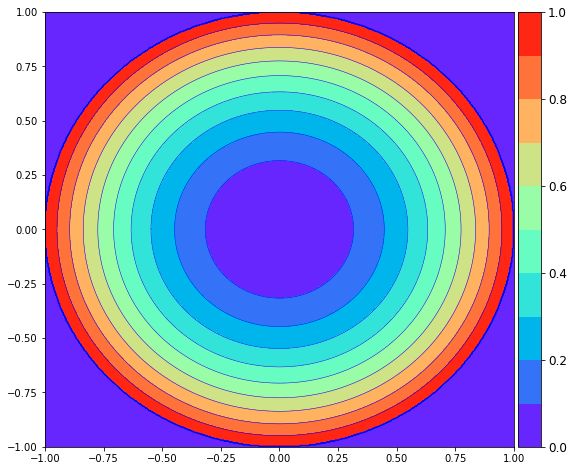

In [54]:
u0 = 1
v0 = 0
wd = 0   # defocus
w040 = 0 # spherical 
w131 = 0 # coma
w222 = 0 # astigmatism
w220 = 1 # field curvature
w311 = 0 # distortion

n = 500 

x = np.linspace(-1, 1, n)
y = np.linspace(-1, 1, n)
X,Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
w = seidel_5(u0,v0,X,Y,wd,w040,w131,w222,w220,w311)
w = np.where(R<=1,w,0)  # nann does not work with plot_surface
p = ryplot.Plotter(1,1,2,figsize=(20,8))
# p.mesh3D(1,X,Y,w)
p.meshContour(2,X,Y,w,cbarshow=True);


1024 samples over 0.001 m in image plane, sample interval is 9.765625e-07 m
Image plane: umin=-0.0005 umax=0.000499023437500001


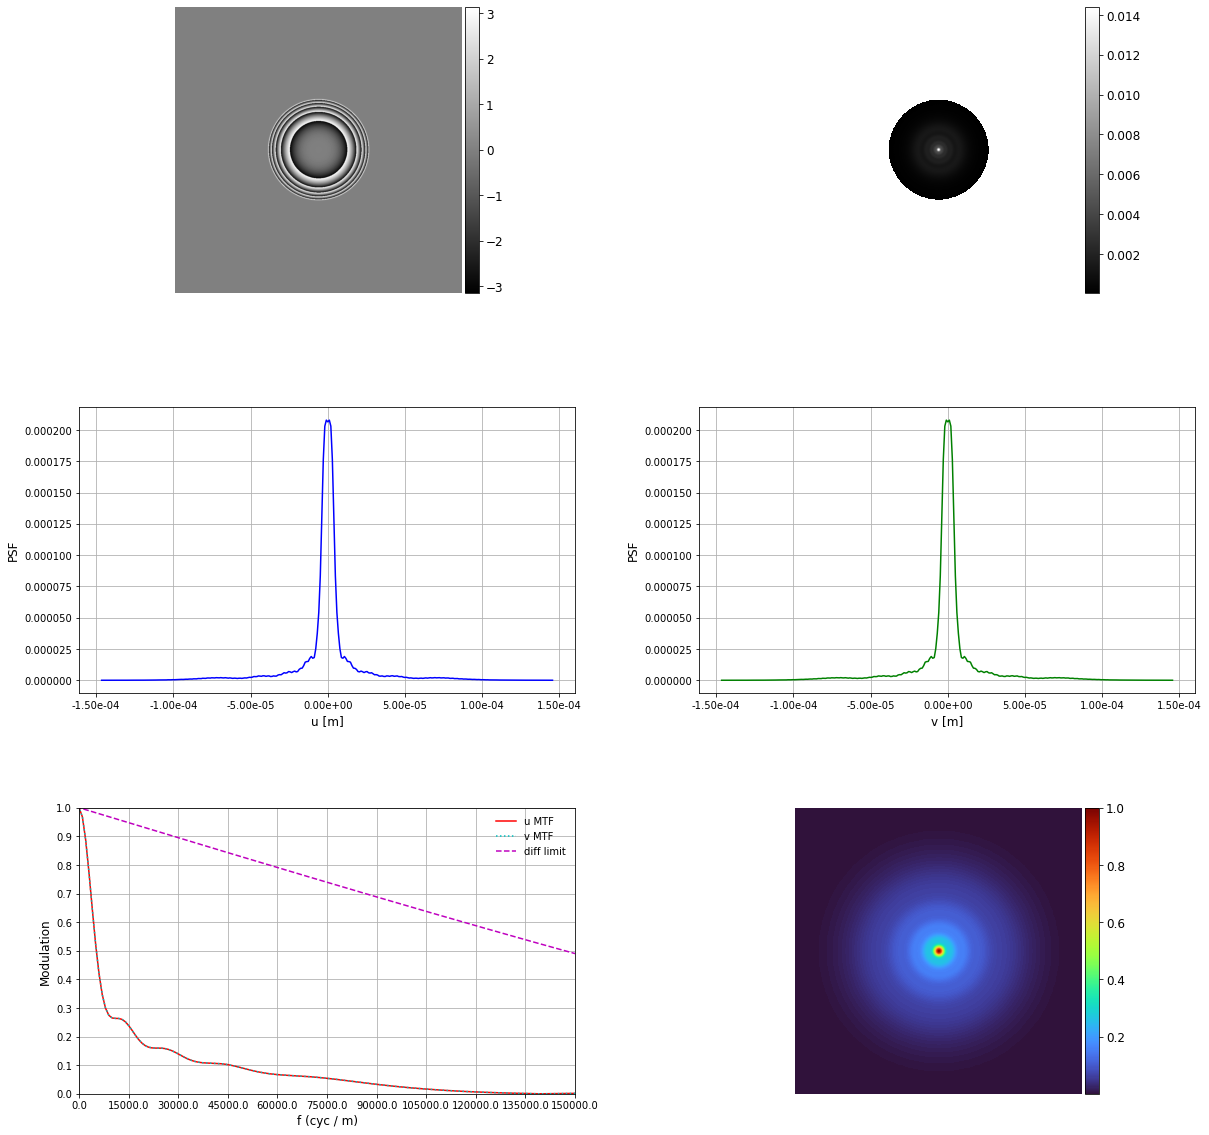

In [192]:
# book page 148

# lens_psfmtf
# f / 5 plano-convex lens (Newport lens KPX094)
# focal length 100 mm
# 10 mm image height
# psf and mtf with Seidel aberrations
# aberration coefficients from ZEMAX

M = 1024 # number samples 
msize = 150  # for display
mmin = np.int(M/2 - msize)
mmax = np.int(M/2 + msize)

L = 1e-3   # [m] image plane size
du = L / M # [m] image plance spatial sample interval

#image plance coordinates
u = np.arange(-L/2,+L/2,du)
v = np.arange(-L/2,+L/2,du) 
U,V = np.meshgrid(u,v)
RUV = np.sqrt(U**2 + V**2)

wavelen = 0.55e-6 # wavelength
k = 2 * np.pi / wavelen # wavenumber
Dxp = 20e-3
wxp = Dxp / 2 # exit pupil size
zxp = 100e-3 # exit pupil distance
fnum = zxp / (2 * wxp) # exit pupil f-number
lz = wavelen * zxp
twof0 = 1 / (wavelen * fnum)  # incoh cutoff freq

print(f'{M} samples over {L} m in image plane, sample interval is {du} m')
print(f'Image plane: umin={np.min(u)} umax={np.max(u)}')

#normalized image coordinate
u0 = 0 
v0 = 0

# aberration coefficients
wd = 0 * wavelen
w040 = 4.963 * wavelen
w131 = 2.637 * wavelen
w222 = 9.025 * wavelen
w220 = 7.536 * wavelen
w311 = 0.157 * wavelen

p = ryplot.Plotter(1,3,2,figsize=(20,20))

# image freq coords
# fu = -1 / (2 * du):1 / L:1 / (2 * du)-(1 / L) 
fu = np.arange(-1 / (2 * du), 1 / (2 * du), 1 / L)
Fu, Fv = np.meshgrid(fu,fu)
R = np.sqrt(Fu**2 + Fv**2)

# # wavefront
W = seidel_5(u0,v0,-Fu*(lz/wxp),-Fv*(lz/wxp),wd,w040,w131,w222,w220,w311)

# # coherent transfer function
H = np.exp(-1j * k * W)
H = np.where(R*lz/wxp<=1,H,0)

# point spread function
h2 = np.abs(np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(H))))**2
# h2 = h2 / np.max(h2)

# # MTF
MTF = np.abs(np.fft.fft2(np.fft.fftshift(h2)))
MTF = MTF / MTF[0,0] #normalize DC to 1
MTF = np.fft.ifftshift(MTF)

# analytic MTF.  ugly clutch necessary to have valid arccos and sqrt
futwof0 = np.where(fu / twof0>0.9999,0.9999,fu / twof0)
futwof0 = np.where(futwof0<-0.9999,-0.9999,futwof0)
MTF_an = (2 / np.pi) * (np.arccos(futwof0)-(futwof0) * np.sqrt(1-(futwof0)**2))
MTF_an = np.where(fu/(2*twof0)<1,MTF_an,np.nan)

p.showImage(1,np.angle(H),xlabel='--',ylabel='--',cbarshow=True);
# p.meshContour(1,U,V,np.angle(H),meshCmap=cm.gray,cbarshow=True,xlabel='u (m)',ylabel='v (m)');
# p.getSubPlot(1).axis('equal')
p.showImage(2,np.sqrt(np.where(R*lz/wxp<=1,h2,np.nan)),xlabel='--',ylabel='--',cbarshow=True);
# p.meshContour(2,U,V,np.sqrt(np.where(R*lz/wxp<=1,h2,np.nan)),meshCmap=cm.gray,cbarshow=True,xlabel='u (m)',ylabel='v (m)');
# p.getSubPlot(2).axis('equal')
p.plot(3,u[mmin:mmax],h2[int(M/2),mmin:mmax],'','u [m]','PSF',maxNX=7,xAxisFmt='%.2e')
p.plot(4,u[mmin:mmax],h2[mmin:mmax,int(M/2)],'','v [m]','PSF',maxNX=7,xAxisFmt='%.2e')
p.plot(5,fu,MTF[int(M/2),:],label=['u MTF'])
p.plot(5,fu,MTF[:,int(M/2)],linestyle=[':'],label=['v MTF'])
p.plot(5,fu,MTF_an,'','f (cyc / m)','Modulation',linestyle=['--'],label=['diff limit'],pltaxis=[0,150000,0,1])
p.showImage(6,MTF[mmin:mmax,mmin:mmax],xlabel='--',ylabel='--',cmap='turbo',cbarshow=True);
# p.meshContour(6,Fu,Fv,MTF,meshCmap=cm.jet,cbarshow=True,levels=40,xlabel='--',ylabel='--');
# p.getSubPlot(6).axis('equal')


1024 samples over 0.001 m in image plane, sample interval is 9.765625e-07 m
Image plane: umin=-0.0005 umax=0.000499023437500001


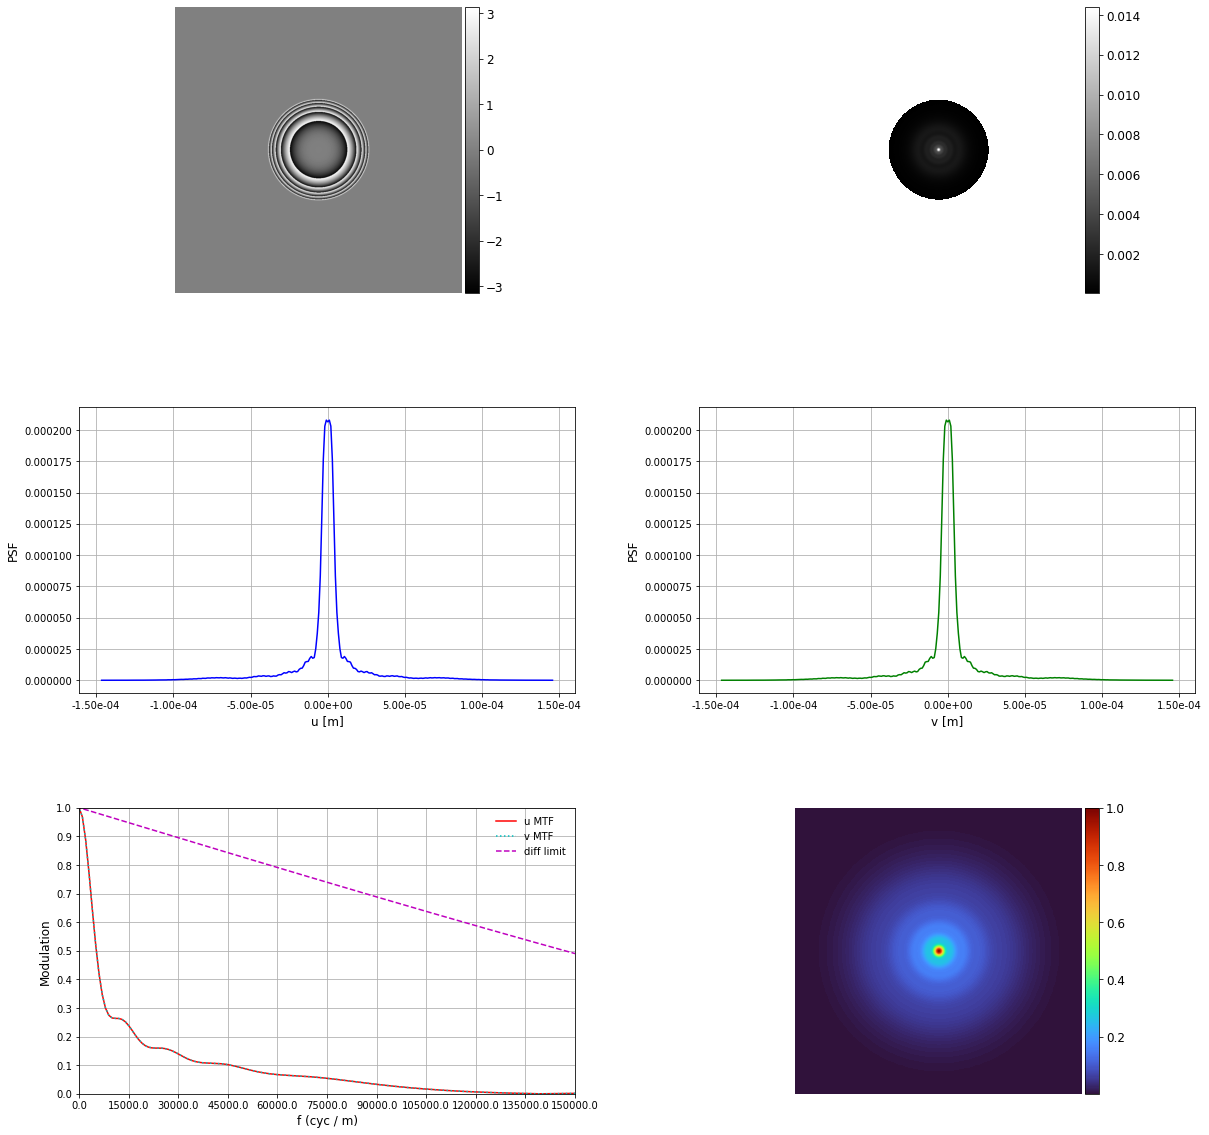

In [193]:
# book page 148

# lens_psfmtf
# f / 5 plano-convex lens (Newport lens KPX094)
# focal length 100 mm
# 10 mm image height
# psf and mtf with Seidel aberrations
# aberration coefficients from ZEMAX

M = 1024 # number samples 
msize = 150  # for limiting display 
mmin = np.int(M/2 - msize)
mmax = np.int(M/2 + msize)

L = 1e-3   # [m] image plane size
du = L / M # [m] image plane spatial sample interval

#image plane coordinates
u = np.arange(-L/2,+L/2,du)
v = np.arange(-L/2,+L/2,du) 
U,V = np.meshgrid(u,v)
RUV = np.sqrt(U**2 + V**2)

wavelen = 0.55e-6 
diaPupil = 20e-3
radPupil = diaPupil / 2 
focalLen = 100e-3                # exit pupil distance
fnum = focalLen / (2 * radPupil) # exit pupil f-number
lz = wavelen * focalLen
cutoffFreq = 1 / (wavelen * fnum)     # incoh cutoff freq

print(f'{M} samples over {L} m in image plane, sample interval is {du} m')
print(f'Image plane: umin={np.min(u)} umax={np.max(u)}')

#normalized image coordinate
u0 = 0 
v0 = 0

# aberration coefficients
wd = 0 * wavelen
w040 = 4.963 * wavelen
w131 = 2.637 * wavelen
w222 = 9.025 * wavelen
w220 = 7.536 * wavelen
w311 = 0.157 * wavelen

p = ryplot.Plotter(1,3,2,figsize=(20,20))

# image freq coords
# fu = -1 / (2 * du):1 / L:1 / (2 * du)-(1 / L) 
fu = np.arange(-1 / (2 * du), 1 / (2 * du), 1 / L)
Fu, Fv = np.meshgrid(fu,fu)
R = np.sqrt(Fu**2 + Fv**2)

# # wavefront
W = seidel_5(u0,v0,-Fu*(lz/radPupil),-Fv*(lz/radPupil),wd,w040,w131,w222,w220,w311)

# # coherent transfer function
H = np.exp(-1j * (2 * np.pi / wavelen) * W)
H = np.where(R*lz/radPupil<=1,H,0)

# point spread function
h2 = np.abs(np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(H))))**2
# h2 = h2 / np.max(h2)

# # MTF
MTF = np.abs(np.fft.fft2(np.fft.fftshift(h2)))
MTF = MTF / MTF[0,0] #normalize DC to 1
MTF = np.fft.ifftshift(MTF)

# analytic MTF.  ugly clutch necessary to have valid arccos and sqrt
futwof0 = np.where(fu / cutoffFreq>0.9999,0.9999,fu / cutoffFreq)
futwof0 = np.where(futwof0<-0.9999,-0.9999,futwof0)
MTF_an = (2 / np.pi) * (np.arccos(futwof0)-(futwof0) * np.sqrt(1-(futwof0)**2))
MTF_an = np.where(fu/(2*cutoffFreq)<1,MTF_an,np.nan)

p.showImage(1,np.angle(H),xlabel='--',ylabel='--',cbarshow=True);
# p.meshContour(1,U,V,np.angle(H),meshCmap=cm.gray,cbarshow=True,xlabel='u (m)',ylabel='v (m)');
# p.getSubPlot(1).axis('equal')
p.showImage(2,np.sqrt(np.where(R*lz/radPupil<=1,h2,np.nan)),xlabel='--',ylabel='--',cbarshow=True);
# p.meshContour(2,U,V,np.sqrt(np.where(R*lz/radPupil<=1,h2,np.nan)),meshCmap=cm.gray,cbarshow=True,xlabel='u (m)',ylabel='v (m)');
# p.getSubPlot(2).axis('equal')
p.plot(3,u[mmin:mmax],h2[int(M/2),mmin:mmax],'','u [m]','PSF',maxNX=7,xAxisFmt='%.2e')
p.plot(4,u[mmin:mmax],h2[mmin:mmax,int(M/2)],'','v [m]','PSF',maxNX=7,xAxisFmt='%.2e')
p.plot(5,fu,MTF[int(M/2),:],label=['u MTF'])
p.plot(5,fu,MTF[:,int(M/2)],linestyle=[':'],label=['v MTF'])
p.plot(5,fu,MTF_an,'','f (cyc / m)','Modulation',linestyle=['--'],label=['diff limit'],pltaxis=[0,150000,0,1])
p.showImage(6,MTF[mmin:mmax,mmin:mmax],xlabel='--',ylabel='--',cmap='turbo',cbarshow=True);
# p.meshContour(6,Fu,Fv,MTF,meshCmap=cm.jet,cbarshow=True,levels=40,xlabel='--',ylabel='--');
# p.getSubPlot(6).axis('equal')
